#  **Phishing Detection using ML and Data Visualization**
### I. Objective
This notebook focuses on **feature extraction from URLs**.  
Both phishing and legitimate URLs are collected, processed, and converted into numerical features.  
These extracted features will later be used in the **Phishing Website Detection** notebook for training machine learning models.


## II. Data Collection

We collect two categories of URLs:

### II.I Phishing URLs  
- Source: [PhishTank](https://www.phishtank.com/developer_info.php)  
- Updated hourly.  
- Label → **1 (Phishing)**  

### II.II Legitimate URLs  
- Source: [Majestic Million](https://majestic.com/reports/majestic-million)  
- Top trusted websites.  
- Label → **0 (Legitimate)**


##III. Data Visualisations
### Insights Summary  

From the above visualizations, we can observe:  

1. **Histogram** → Phishing URLs generally have **longer lengths**, indicating attackers use complex structures with subdomains and parameters.  
2. **Bar & Pie Charts** → Dataset has a clear **class distribution** (Phish vs Legit). This helps us confirm if the dataset is balanced or needs balancing.  
3. **Scatter Plot** → Phishing URLs tend to cluster with **higher digit counts and longer lengths**, while legitimate URLs are shorter and cleaner.  
4. **Box Plot** → Phishing URLs show **greater variability** and often lie above the median length of legitimate URLs.  
5. **Heatmap** → Strong correlations between features (e.g., URL length, digit count, and special characters) and the phishing label suggest these are **useful predictive features**.  

 These insights confirm that **lexical features extracted from URLs are highly effective indicators for phishing detection**.  


### Step 0: Install & Import Dependencies


In [89]:
!pip install tldextract seaborn plotly squarify wordcloud -q

import pandas as pd
import numpy as np
import re
import tldextract
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
import plotly.graph_objects as go
from urllib.parse import urlparse
import ipaddress
import requests


### Step 1: Load Phishing URLs


In [90]:
url = "http://data.phishtank.com/data/online-valid.csv"

try:
    # Load into pandas directly from the URL
    phish_data = pd.read_csv(url, encoding='utf-8')[['url']]
    phish_data['label'] = 1
    print("Phishing URLs Loaded:", phish_data.shape)
    display(phish_data.head())
except Exception as e:
    print(f"Failed to load data from URL: {e}")
    print("Please download 'online-valid.csv' manually from PhishTank, upload it to your Colab environment, and load it using `pd.read_csv('online-valid.csv')`.")


Phishing URLs Loaded: (51314, 2)


,url,label
0,https://arbfrape536234.blob.core.windows.net/s...,1
1,https://confirmation-docamzsupport.nationsacco...,1
2,https://caixadirecta-acessar.com/login.php,1
3,https://www.espace-client-ulys.com/,1
4,https://espace-client-ulys.com/,1


### Step 2: Load Legitimate URLs


In [91]:
# Update path if downloading manually
legit_data = pd.read_csv("majestic_million.csv")[['Domain']]
legit_data.rename(columns={'Domain': 'url'}, inplace=True)
legit_data['label'] = 0

print(" Legitimate URLs Loaded:", legit_data.shape)
legit_data.head()


 Legitimate URLs Loaded: (1000000, 2)


,url,label
0,google.com,0
1,facebook.com,0
2,youtube.com,0
3,instagram.com,0
4,twitter.com,0


### Step 3: Combine Both Datasets


In [92]:
data = pd.concat([phish_data, legit_data], ignore_index=True)
print(" Combined Dataset Shape:", data.shape)
data.head()


 Combined Dataset Shape: (1051314, 2)


,url,label
0,https://arbfrape536234.blob.core.windows.net/s...,1
1,https://confirmation-docamzsupport.nationsacco...,1
2,https://caixadirecta-acessar.com/login.php,1
3,https://www.espace-client-ulys.com/,1
4,https://espace-client-ulys.com/,1


### Step 4: Feature Extraction Helpers


In [93]:
def has_ip_address(url):
    try:
        hostname = urlparse(url).hostname
        ipaddress.ip_address(hostname)
        return 1
    except:
        return 0

def has_at_symbol(url):
    return 1 if '@' in url else 0

def has_redirection(url):
    pos = url.find('//')
    return 1 if url.find('//', pos+2) != -1 else 0

def get_domain_features(url):
    ext = tldextract.extract(url)
    domain = ext.domain
    subdomain = ext.subdomain
    suffix = ext.suffix
    return {
        'domain_length': len(domain),
        'num_dots_domain': domain.count('.'),
        'has_hyphen_domain': 1 if '-' in domain else 0,
        'tld': suffix,
        'subdomain_length': len(subdomain),
        'num_dots_subdomain': subdomain.count('.')
    }


### Step 5: Extract Features for Each URL


In [94]:
# Step 5: Extract Features for Each URL
def extract_features(url):
    parsed = urlparse(url)
    feats = {}
    feats['url_length'] = len(url)
    feats['hostname_length'] = len(parsed.hostname) if parsed.hostname else 0
    feats['path_length'] = len(parsed.path)
    feats['digit_count'] = sum(c.isdigit() for c in url)
    feats['special_count'] = sum(not c.isalnum() for c in url)
    feats['has_ip'] = has_ip_address(url)
    feats['has_at'] = has_at_symbol(url)
    feats['has_redirection'] = has_redirection(url)
    feats.update(get_domain_features(url))
    return feats

# Apply feature extraction
features = data['url'].apply(extract_features)
features_df = pd.DataFrame(features.tolist())

# Merge with labels
final_df = pd.concat([data.reset_index(drop=True), features_df], axis=1)

print(" Final Dataset Shape:", final_df.shape)
final_df.head()


 Final Dataset Shape: (1051314, 16)


,url,label,url_length,hostname_length,path_length,digit_count,special_count,has_ip,has_at,has_redirection,domain_length,num_dots_domain,has_hyphen_domain,tld,subdomain_length,num_dots_subdomain
0,https://arbfrape536234.blob.core.windows.net/s...,1,80,36,36,14,10,0,0,0,7,0,0,net,24,2
1,https://confirmation-docamzsupport.nationsacco...,1,73,44,21,1,11,0,0,0,11,0,0,co.ke,26,0
2,https://caixadirecta-acessar.com/login.php,1,42,24,10,0,7,0,0,0,20,0,1,com,0,0
3,https://www.espace-client-ulys.com/,1,35,26,1,0,8,0,0,0,18,0,1,com,3,0
4,https://espace-client-ulys.com/,1,31,22,1,0,7,0,0,0,18,0,1,com,0,0


In [95]:
# Apply feature extraction functions to the combined data
def extract_features(url):
    features = {}
    features['url_length'] = len(url)
    features['hostname_length'] = len(urlparse(url).hostname) if urlparse(url).hostname else 0
    features['path_length'] = len(urlparse(url).path)
    features['digit_count'] = sum(c.isdigit() for c in url)
    features['special_count'] = len(re.findall(r'[!@#$%^&*()-=_+{};:\'",.<>/?`~|\\\[\]]', url))
    features['has_ip'] = has_ip_address(url)
    features['has_at'] = has_at_symbol(url)
    features['has_redirection'] = has_redirection(url)

    domain_features = get_domain_features(url)
    features.update(domain_features)

    return features

# Apply the feature extraction to the 'url' column
features = data['url'].apply(extract_features)

# Convert the list of dictionaries into a DataFrame
features_df = pd.DataFrame(features.tolist())

# Combine features with the original data and label
final_df = pd.concat([data, features_df], axis=1)

print("Final DataFrame with features:", final_df.shape)
display(final_df.head())

# Save the final_df to a CSV file
final_df.to_csv('final_features.csv', index=False)

print("final_features.csv saved successfully!")

Final DataFrame with features: (1051314, 16)


,url,label,url_length,hostname_length,path_length,digit_count,special_count,has_ip,has_at,has_redirection,domain_length,num_dots_domain,has_hyphen_domain,tld,subdomain_length,num_dots_subdomain
0,https://arbfrape536234.blob.core.windows.net/s...,1,80,36,36,14,24,0,0,0,7,0,0,net,24,2
1,https://confirmation-docamzsupport.nationsacco...,1,73,44,21,1,12,0,0,0,11,0,0,co.ke,26,0
2,https://caixadirecta-acessar.com/login.php,1,42,24,10,0,7,0,0,0,20,0,1,com,0,0
3,https://www.espace-client-ulys.com/,1,35,26,1,0,8,0,0,0,18,0,1,com,3,0
4,https://espace-client-ulys.com/,1,31,22,1,0,7,0,0,0,18,0,1,com,0,0


final_features.csv saved successfully!


### Step 6: Visualizations


#### 1. Histogram — URL Length Distribution  
The histogram shows how URL lengths are distributed across the dataset.  
 Phishing URLs usually tend to be longer than legitimate ones because attackers add extra subdomains, parameters, and obfuscations.  


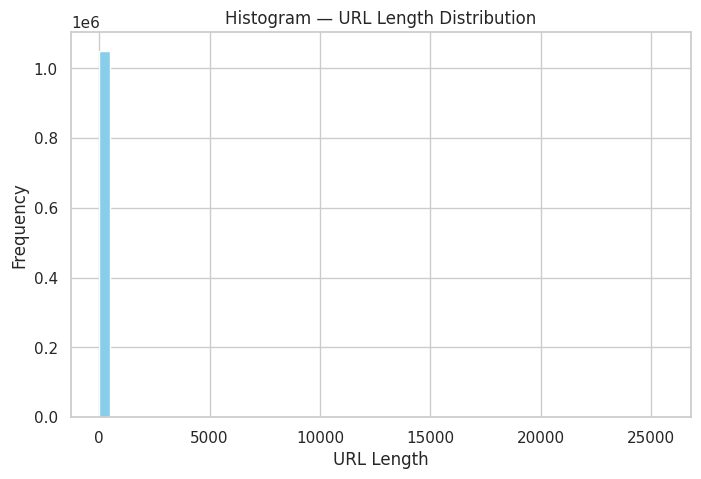

In [96]:
sns.set(style="whitegrid")

plt.figure(figsize=(8,5))
plt.hist(final_df['url_length'], bins=50, color='skyblue')
plt.title("Histogram — URL Length Distribution")
plt.xlabel("URL Length")
plt.ylabel("Frequency")
plt.show()

#### 2. Bar Chart — Class Distribution  
This bar chart displays the number of phishing vs legitimate URLs.  
 It helps us quickly check **dataset balance** (whether we have enough samples for both classes).  


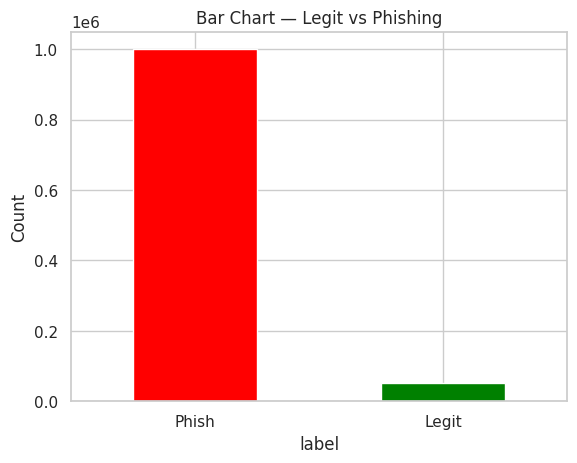

In [97]:
final_df['label'].value_counts().plot(kind='bar', color=['red','green'])
plt.title("Bar Chart — Legit vs Phishing")
plt.xticks([0,1], ["Phish","Legit"], rotation=0)
plt.ylabel("Count")
plt.show()


#### 3. Pie Chart — Dataset Split  
The pie chart shows the proportion of phishing vs legitimate URLs.  
 Useful for understanding class imbalance visually (e.g., 60% phishing vs 40% legit).  


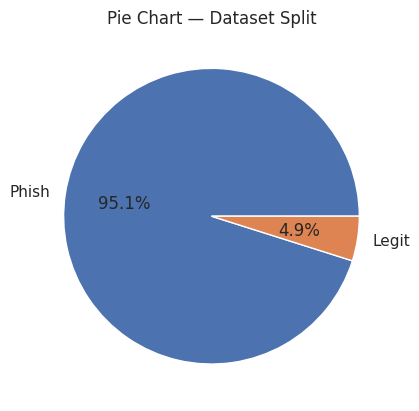

In [98]:
final_df['label'].value_counts().plot(kind='pie', labels=['Phish','Legit'], autopct='%1.1f%%')
plt.title("Pie Chart — Dataset Split")
plt.ylabel("")
plt.show()


#### 4. Scatter Plot — URL Length vs Digit Count  
The scatter plot shows the relationship between URL length and digit count, with colors representing classes.  
 Phishing URLs often appear in the **top-right** region (longer URLs with more digits).  


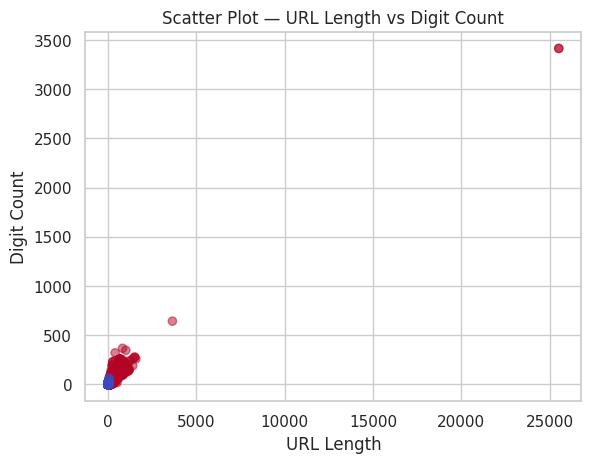

In [99]:
plt.scatter(final_df['url_length'], final_df['digit_count'],
            c=final_df['label'], alpha=0.5, cmap="coolwarm")
plt.title("Scatter Plot — URL Length vs Digit Count")
plt.xlabel("URL Length")
plt.ylabel("Digit Count")
plt.show()


#### 5. Box Plot — URL Length by Class  
The box plot compares the distribution of URL length across phishing and legitimate classes.  
 Median and quartiles show phishing URLs generally have **higher lengths and more variability**.  


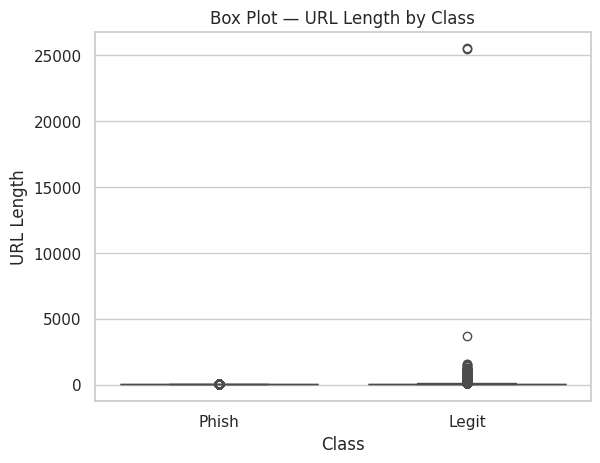

In [100]:
sns.boxplot(x='label', y='url_length', data=final_df)
plt.title("Box Plot — URL Length by Class")
plt.xticks([0,1], ["Phish","Legit"])
plt.xlabel("Class")
plt.ylabel("URL Length")
plt.show()


#### 6. Heatmap — Feature Correlation  
The heatmap shows correlations between extracted numerical features and the label.  
 Helps us identify **which features strongly influence phishing classification** (e.g., URL length and digit count might be positively correlated with phishing).  


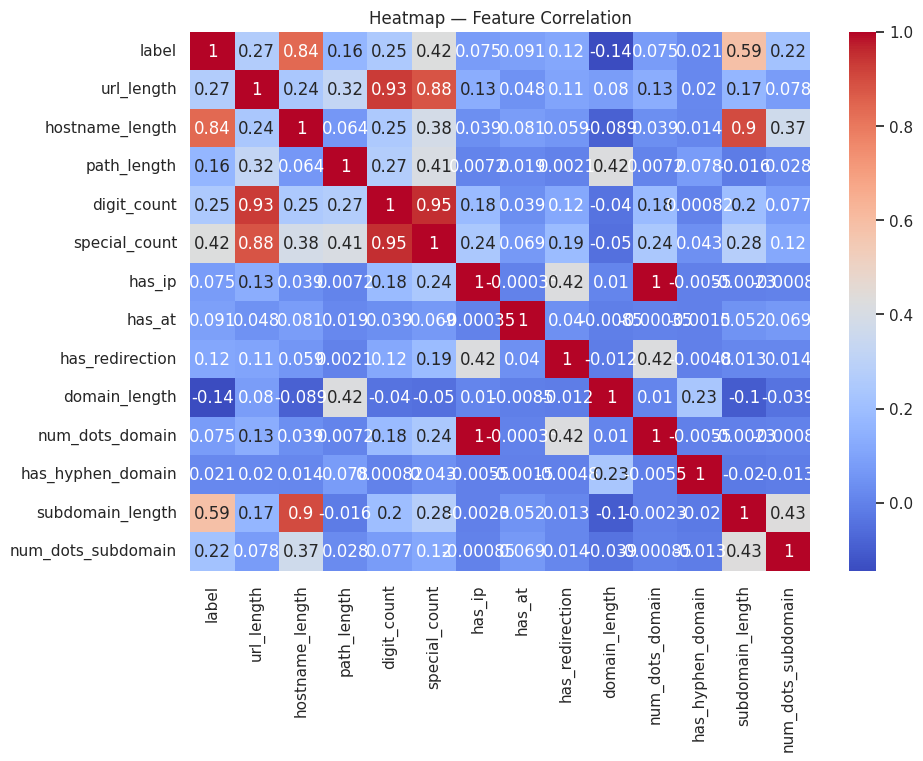

In [101]:
plt.figure(figsize=(10,7))
sns.heatmap(final_df.select_dtypes(include=np.number).corr(), annot=True, cmap="coolwarm")
plt.title("Heatmap — Feature Correlation")
plt.show()


#### Step 7: Select Final Features for ML


In [102]:
selected_features = [
    'url_length','hostname_length','path_length','digit_count','special_count',
    'has_ip','has_at','has_redirection',
    'domain_length','has_hyphen_domain',
    'subdomain_length','num_dots_domain','num_dots_subdomain'
]

print(" Features ready for ML:", selected_features)


 Features ready for ML: ['url_length', 'hostname_length', 'path_length', 'digit_count', 'special_count', 'has_ip', 'has_at', 'has_redirection', 'domain_length', 'has_hyphen_domain', 'subdomain_length', 'num_dots_domain', 'num_dots_subdomain']


###  Conclusion

- **Extracted URL lexical features** →  
  Length, hostname, path, digits, special characters, redirection, IP check, subdomain info, etc.

- **Created `final_features.csv`** →  
  Feature-rich dataset containing URLs, labels, and engineered features.

- **Visualization Insights** →  
  Phishing URLs are generally longer, contain more digits, and include more special characters or subdomains compared to legitimate ones.

- **`final_features.csv` is ready for**:
  - Export (`.csv`)
  - Can be used in another notebook for training & evaluating ML models for phishing detection